In [475]:
# -----------------------------------------------------------
# Simulates the dn = 0 evolution from an initial surface in 2 dimensions
# for an Euclidean and Minkowski metric.
#
# (C) 2022 Florian Babisch, Tübingen, Germany
# Released under CC-BY license
# email flofe@t-online.de
# -----------------------------------------------------------

# This code uses the numpy convention for docstrings

In [476]:
from cmath import inf
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator
import numpy as np
import sympy as sy
from sympy import *
import math
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, HBox, VBox, Layout, Dropdown
from IPython.display import display, clear_output
import ipywidgets as widgets

In [477]:
# SymPy symbols
# In the following x cannot be used as a variable for anything else!
x = Symbol('x')

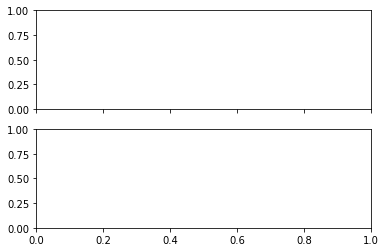

In [478]:
# Global figure
# Set sharex to False if you want to save an image of only the first axis
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

In [479]:
# Class is not written by me, source: 
# https://stackoverflow.com/questions/13054758/python-finding-multiple-roots-of-nonlinear-equation
class ClassRoots:
    def __init__(self):
        pass

    def rootsearch(self,f,a,b,dx):
        x1 = a; f1 = f(a)
        x2 = a + dx; f2 = f(x2)
        while f1*f2 > 0.0:
            if x1 >= b:
                return None,None
            x1 = x2; f1 = f2
            x2 = x1 + dx; f2 = f(x2)
        return x1,x2

    def bisect(self, f,x1,x2,switch=0,epsilon=1.0e-9):
        f1 = f(x1)
        if f1 == 0.0:
            return x1
        f2 = f(x2)
        if f2 == 0.0:
            return x2
        if f1*f2 > 0.0:
            #print('Root is not bracketed')
            return None
        n = int(math.ceil(math.log(abs(x2 - x1)/epsilon)/math.log(2.0)))
        for i in range(n):
            x3 = 0.5*(x1 + x2); f3 = f(x3)
            if (switch == 1) and (abs(f3) >abs(f1)) and (abs(f3) > abs(f2)):
                return None
            if f3 == 0.0:
                return x3
            if f2*f3 < 0.0:
                x1 = x3
                f1 = f3
            else:
                x2 =x3
                f2 = f3
        return (x1 + x2)/2.0

    def roots(self,f, a, b, eps=1e-6):
        #print ('The roots on the interval [%f, %f] are:' % (a,b))
        zeros = []
        while 1:
            x1,x2 = self.rootsearch(f,a,b,eps)
            if x1 != None:
                a = x2
                root = self.bisect(f,x1,x2,1)
                if root != None:
                    pass
                    #print (round(root,-int(math.log(eps, 10))))
                    zeros.append(round(root,-int(math.log(eps, 10))))
            else:
                #print(zeros)
                #print ('\nDone')
                break
        return zeros

In [480]:
def isfloat(input):
    """ Check if input is float or not.

        Parameters
        ----------
        input : any
            Input that is analyzed.

        Returns
        -------
        boolean
            Tells whether the input is float or not.
    """
    try:
        float(input)
        return True
    except ValueError:
        return False
    except TypeError:
        return False


def transform_function(xValues, func):
    """Transforms expression of a function into a numpy expression and returns two lists of values.

        Parameters
        ----------
        xValues : list
            List of x-coordinates.
        func: SymPy type
            Function that is to be evaluated at the given x-coordinates.

        Returns
        -------
        tuple
            The x-coordinates and the function evaluated at the coordinates.
    """
    if isfloat(func):
        npFunc = [func for i in range(len(xValues))]
        return xValues, npFunc
    npFunc = lambdify(x, func, 'numpy')
    return xValues, npFunc(xValues)


def transform_vector(xValues, vector):
    """Transforms tuple of sympy expressions into a tuple of numpy expression and evaluates at the
       given x-coordinates.

        Parameters
        ----------
        xValues : list
            List of x-coordinates.
        vector : tuple
            Vector with two components that is to be evaluated at the given x-coordinates.
        
        Returns
        -------
        tuple 
            Components of the vector evaluated at the given x-coordinates.
    """
    npFunc0 = lambdify(x, vector[0], 'numpy')
    npFunc1 = lambdify(x, vector[1], 'numpy')
    v0 = npFunc0(xValues)
    v1 = npFunc1(xValues)
    return v0, v1


def euclidean_normal_vector(func):
    """Calculates normal vector with Euclidean metric.
    
        Parameters
        ----------
        func : SymPy type
            Function of which the normal vector is calculated.
        
        Returns
        -------
        tuple 
           Normal vector of given function.
    """
    funcPrime = func.diff(x)
    return -funcPrime, 1


def minkowski_normal_vector(func):
    """Calculates normal vector with Minkowski metric.
    
        Parameters
        ----------
        func : SymPy type
            Function of which the normal vector is calculated.

        Returns
        -------
        tuple
            Normal vector of given function.
    """
    funcPrime = func.diff(x)
    return funcPrime, 1


def euclidean_normal_values(xValues, func):
    """Create x- and y-values for the Euclidean normal vector of the given function.
        
        Parameters
        ----------
        xValues : list
            List of x-coordinates.
        func : SymPy type
            Function for which the values of the unit normal vectors are created.

        Returns
        -------
        tuple 
            The x- and y-values of the normal vector of the given function.
    """
    # check if function is constant
    if isfloat(func):
        f = [0 for i in range(len(xValues))]
        xValues = [1 for i in range(len(xValues))]
        return f, xValues
    else:
        return euclidean_unit_vector(transform_vector(xValues, euclidean_normal_vector(func)))


def minkowski_normal_values(xValues, func):
    """Create x- and y-values for the Minkowski normal vector of the given function.
        
        Parameters
        ----------
        xValues : list
            List of x-coordinates.
        func : SymPy type
            Function for which the values of the unit normal vectors are created.

        Returns
        -------
        tuple 
            The x- and y-values of the normal vector of the given function.
    """
    if isfloat(func):
        f = [0 for i in range(len(xValues))]
        xValues = [1 for i in range(len(xValues))]
        return f, xValues
    return minkowski_unit_vector(transform_vector(xValues, minkowski_normal_vector(func)))


def euclidean_norm(vector):
    """Calculates Euclidean norm of 2 dimensional vector.
    
        Parameters
        ----------
        vector : tuple
            Vector with two components.
        
        Returns
        -------
        float
            Euclidean norm of the given vector.
    """
    return np.sqrt(vector[0]**2 + vector[1]**2)


def minkowski_norm(vector):
    """Calculates Minkowski norm of 2 dimensional vector with (+-) signature.
    
        Parameters
        ----------
        vector : tuple
            Vector with two components.
        
        Returns
        -------
        float
            Minkowski norm of the given vector.
    """
    radicand = np.abs(vector[0]**2 - vector[1]**2)
    return np.sqrt(radicand)


def euclidean_unit_vector(vector):
    """Normalize 2 dimensional vector from Euclidean space.
    
        Parameters
        ----------
        vector : tuple
            Vector with two components.
        
        Returns
        -------
        tuple
            Normalized components of the given vector.
    """
    norm = euclidean_norm(vector)
    return vector[0] / norm, vector[1] / norm


def minkowski_unit_vector(vector):
    """Normalize 2 dimensional vector from Minkowski space.
    
        Parameters
        ----------
        vector : tuple
            Vector with two components.
        
        Returns
        -------
        tuple
            Normalized components of the given vector.
    """
    norm = minkowski_norm(vector)
    if any(entry == 0 for entry in norm) == False:
        return vector[0] / norm, vector[1] / norm
    else:
        return vector[0], vector[1]
        

def euclidean_inner_product(v, w):
    """Calculates the Eucldiean inner product of two 2 dimensional vectors.
    
        Parameters
        ----------
        v : tuple 
            Vector with two components.
        w : tuple
            Vector with two components.
        
        Returns
        -------
        float 
            Inner product of v and w.
    """
    return v[0] * w[0] + v[1] * w[1]

def minkowski_inner_product(v, w):
    """Calculates the Minkowski inner product of two 2 dimensional vectors.
    
        Parameters
        ----------
        v : tuple 
            Vector with two components.
        w : tuple
            Vector with two components.
        
        Returns
        -------
        float 
            Inner product of v and w.
    """
    return v[0] * w[0] - v[1] * w[1]


def euclidean_angle_between_vectors(v,w):
    """Calculates angle between two 2 dimensional vectors in Euclidean space.
    
        Parameters
        ----------
        v : tuple 
            Vector with two components.
        w : tuple
            Vector with two components.
        
        Returns
        -------
        float 
            Angle between the vectors v and w.
    """
    return np.arccos(euclidean_inner_product(v / np.linalg.norm(v), w / np.linalg.norm(w)))


def unit_circle(t, center):
    """Calculate values of a unit circle around a given point.
    
        Parameters
        ----------
        t : list
            Values that parametrize the circle.
        center : tuple
            Point around which the unit circle is centered. 

        Returns
        -------
        tuple
            The x- and y-values of the points of the unit circle.
    """
    px = center[0] + np.cos(t)
    py = center[1] + np.sin(t)
    return px, py 


def circle(t, center, radius):
    """Calculate values of a circle with given radius centered around a given point.

        Parameters
        ----------
        t : list
            Values that parametrize the circle.
        center : tuple
            Point around which the circle is centered.
        radius : float
            Radius of the circle.
       
        Returns
        -------
        tuple
            The x- and y-values of the points of the unit circle.
    """
    px = center[0] + np.cos(t) * radius
    py = center[1] + np.sin(t) * radius
    return px, py 


def curvature(func):
    """Calculate signed curvature of the given function.
    
        Parameters
        ----------
        func : SymPy type
            Function of which the curvature is calculated.
        
        Returns
        -------
        SymPy type 
            Signed curvature of given function.
    """
    funcPrime = func.diff()
    func2Prime = funcPrime.diff()
    k = func2Prime / (1 + funcPrime**2)**(3 / 2)
    return k


def extrema(interval, func):
    """Finds extrem points of function.
    
        Parameters
        ----------
        interval : tuple
            Interval limits in which extrema are searched for.
        func : SymPy type
            Function of which the extram are determined.
        
        Returns
        -------
        list
            Roots of first derivative of the given function.
    """
    funcPrime = func.diff()
    npFuncPrime = lambdify(x, funcPrime, 'numpy')
    cr = ClassRoots()
    roots = cr.roots(npFuncPrime, *interval)
    return roots


def osculating_circle(point, func):
    """Calculates the radius and center of the osculating circles of a function at a given point.
    
        Parameters
        ----------
        point : tuple
            The x- and y-coordinate of the point of a function at which the osculating circle is calculated.
        func : SymPy type
            Function for which the osuclating circle is calculated at the given point.

        Returns
        -------
        list
            Radius and x- and y-coordinate of center of the osculating circle.
    """
    px, py = point
    if isfloat(func): return 0,0,0
    funcPrime = func.diff()
    func2Prime = funcPrime.diff()
    npFuncPrime = lambdify(x, funcPrime, 'numpy')
    npFunc2Prime = lambdify(x, func2Prime, 'numpy')
    if npFunc2Prime(px) == 0: return 0,0,0
    else:
        r = np.abs(((1 + npFuncPrime(px) ** 2) ** (3 / 2)) / npFunc2Prime(px))
        kx = px - (npFuncPrime(px)*(1 + npFuncPrime(px)**2)) / npFunc2Prime(px)
        ky = py + (1 + npFuncPrime(px)**2) / npFunc2Prime(px)
    return r, kx, ky


def find_duplicates(lst):
    """Returns duplicates in a given list.
    
        Parameters
        ----------
        lst : list
            List of values.
        
        Returns
        -------
        list 
            Values that appeared more than once.
    """
    seen = set()
    uniques, duplicates = [], []
    for x in lst:
        if x not in seen:
            uniques.append(x)
            seen.add(x)
        else:
            duplicates.append(x)
    return duplicates


def closest_value(list, value):
    """Returns value closest to the input value in a given list.
        
        Parameters
        ----------
        lst : list
            List of numbers.
        value : float
            Value of which the closest element in the list is searched for.

        Returns
        -------
        tuple
            Index of element of array that is closest to the given value and the corresponding value in the list.
    """
    arr = np.asarry(list)
    index = (np.abs(arr - value)).argmin()
    return index, arr[index]


def smallest_distance(lst):
    """Find smallest distance between neighboring elements of a list.

        Parameters
        ----------
        lst : list
            List of numbers.
    
        Returns
        -------
        float
            Smallest distance between neighboring elements.
    """
    length = len(lst)
    distances = []
    for i in range(length-1):
        if i < length:
            distances.append(np.abs(lst[i] - lst[i+1]))
    return np.min(distances)


def index_normal_sign_flip(surface):
    """ Returns index of x-coordinate where a sign flip of the normal vectors appears.

        Parameters
        ----------
        surface : tuple
            The x- and y-coordinates of a 1-surface.

        Returns
        -------
        integer
            Index of x-coordinate where the normal vector of the surfaces changes sign.
    """
    if len(surface[0]) == len(surface[1]): length = len(surface[0])
    for i in range(length-1):
        if (surface[0][i] < 0 and surface[0][i+1] > 0) or (surface[0][i] > 0 and surface[0][i+1] < 0):
            return i


def angle_at_sign_flip(surface):
    """Returns the angle between the two normal vectors of a 1-surface 
       at which the x-component changes sign.
    
        Parameters
        ----------
        surface : tuple
            The x- and y-coordinates of a 1-surface.
        
        Returns
        -------
        float 
            Angle between two normal vectors that have different sign in the x-component.
    """
    i = index_normal_sign_flip(surface)
    sx,sy = surface
    u = [sx[i], sy[i]]
    v = [sx[i+1], sy[i+1]]
    return euclidean_angle_between_vectors(u, v)


def push_surface(initialSurface, unitNormalVector, s):
    """Push initial surface along normals.
    
        Parameters
        ----------
        initialSurface : tuple
            The x- and y-coordinates of the initial 1-surface.
        unitNormalVector : tuple
            The x- and y-coordinates of the unit normal vectors of the initial surface.
        
        Returns
        -------
        tuple
            The x- and y-coordinates of the surface pushed along the normals.
    """
    isx, isy = initialSurface
    nx, ny = unitNormalVector
    isx = np.array(isx)
    isy = np.array(isy)
    nx = np.array(nx)
    ny = np.array(ny)
    xSigma_s = nx * s + isx
    ySigma_s = ny * s + isy
    return xSigma_s, ySigma_s

# the following two methods 'intersection' and 'calculate_self_intersection' are adapted from 
# https://stackoverflow.com/questions/65532031/how-to-find-number-of-self-intersection-points-on-2d-plot

def intersection(x1,x2,x3,x4,y1,y2,y3,y4):
    """Calculate the point where two lines constructed from 4 points intersect.

        Parameters
        ----------
        xi : float
            The x-coordinate of a point in 2 dimensional space.
        yi : float
            The y-coordinate of a point in 2 dimensional space.

        Returns 
        -------
        tuple
            The x- and y-coordinate of the point where the two lines intersect.
    """
    d = (x1-x2)*(y3-y4) - (y1-y2)*(x3-x4)
    if d:
        xs = ((x1*y2-y1*x2)*(x3-x4) - (x1-x2)*(x3*y4-y3*x4)) / d
        ys = ((x1*y2-y1*x2)*(y3-y4) - (y1-y2)*(x3*y4-y3*x4)) / d
        if (xs >= min(x1,x2) and xs <= max(x1,x2) and
            xs >= min(x3,x4) and xs <= max(x3,x4)):
            return xs, ys


def calculate_self_intersections(surface):
    """Find all the points where a 1-surface self-intersects.

        Parameters
        ----------
        surface : tuple
            x- and y-coordinates of some surface in 2 dimensional space.
        
        Returns
        -------
        tuple
            x- and y-coordinates of self-intersections.
    """
    xs, ys = [], []
    nsx, nsy = surface
    for i in range(len(nsx)-1):
        for j in range(i-1):
            if xs_ys := intersection(nsx[i],nsx[i+1],nsx[j],nsx[j+1],nsy[i],nsy[i+1],nsy[j],nsy[j+1]):
                xs.append(xs_ys[0])
                ys.append(xs_ys[1])
    return xs, ys


def parameter_self_intersection(
        xValues,
        func,
        numberOfSurfaces, 
        spacing, 
        initialSurface, 
        unitNormalVector, 
        direction):
    """Returns list of parameter intervals of the swallow tails of the surfaces 
        obtained by pushing the initial surface along the normals. 
       
        Notes
        -----
        Currently this does not generally work, e.g., for the exponential function, 
        because there the swallow tails are tilted. This does also not work when 
        the swallow tails get so large that they intersect another swallow tail.
        Also, if some swallow tail is only partly drawn, in the sense that the point of 
        self-intersection is not included, then the swallow tail will still be visible.
        In that case it advised to reduce the number of surfaces drawn by one.
        
        Parameters
        ----------
        xValues : list
            List of x-coordinates.
        func : SymPy type
            Function that characterizes the initial surface.
        numberOfSurfaces : integer
            Number of surfaces that are drawn.
        spacing : integer
            The distance between two surfaces is by standard 1. 
            Using this parameter the distance can be scaled as 1 / spacing.
        initialSurface : tuple
            The x- and y-coordinates of initial surface.
        unitNormalVector : tuple
            The x- and y-coordinates of normal vectors of initial surface.
        direction : integer
            Is either +1 or -1 depending on direction in which the initial surfaces is pushed along the normals.
        
        Returns
        -------
        list
            Parameter intervals of swallow tails.
    """
    allTailIntervals = []
    npF = lambdify(x, func, 'numpy')
    distance = numberOfSurfaces / spacing
    s = distance * direction
    newSurface = push_surface(initialSurface, unitNormalVector, s)
    xs, ys = calculate_self_intersections(newSurface)
    if not xs or not ys: return [[nan, nan]]
    if len(xs) == len(ys): lengthSelfInts = len(xs)

    # Create list of intervals of parameters that parametrize the swallow tail
    # this is done for every point where the surface self-intersects, because there the swallow tails start
    # Assumption: The swallow tails are not tilted and do not intersect another swallow tail of the same surface.
    # Procedure: 
    # 1) Find the point where the surface self-intersects
    # 2) Consider only points of the surface that lie in a region 0.02 to the left and 0.02 to the right of point of self-intersection
    # 2.1) Note that x-values are always 0.01 apart from one another.
    # 3) Consider only points that lie above or below the swallow tail depending on how it is oriented
    # 3.1) For s > 0 the swallow tail is below the surface and for s < 0 it is above the surface
    # 4) Divide the remaining points into points that lie to the left and to the right of the self-intersection
    # 5) Take the largest x-value of the points to the left of the self-intersection and the smallest x-value
    #    of the points to the right of the self-intersection. These are the x-values that define the parameter
    #    interval of the swallow tail.

    for i in range(lengthSelfInts):
        tailInterval, leftxValue, rightxValue = [], [], []
        for xValue in xValues:
            normal = euclidean_normal_values(xValue, func)
            nx = normal[0] * s + xValue
            ny = normal[1] * s + npF(xValue)
            if np.abs(xs[i] - nx) <= 0.02:
                if s > 0:
                    if ny >= ys[i]:
                        if nx < xs[i]:
                            leftxValue.append(xValue)
                        else:
                            rightxValue.append(xValue)
                else:
                    if ny <= ys[i]:
                        if nx < xs[i]:
                            leftxValue.append(xValue)
                        else:
                            rightxValue.append(xValue)
        if leftxValue and rightxValue:
            tailInterval = [np.max(leftxValue), np.min(rightxValue)]
        else: tailInterval = [nan, nan]
        allTailIntervals.append(tailInterval)
    if allTailIntervals:
        return allTailIntervals         


def draw_extrema(interval, func):
    """Draws points where given function has extrema.
    
        Parameters
        ----------
        interval : list
            First entry is lower interval limit and second entry is uper interval limit. 
            This gives the interval in which extrema are searched for.
        func : SymPy type
            Function for which the extrema are searched for.
    """
    roots = np.array(extrema(interval, func))
    print('Extrema: ', roots)
    npFunc = lambdify(x, func, 'numpy')
    ax1.scatter(roots, npFunc(roots), color='red', marker='o')


def draw_curvature(xValues, func):
    """Draws signed curvature.
    
        Parameters
        ----------
        xValues : list
            List of x-coordinates.
        func : SymPy type
            Function of which the curvature is drawn.
    """
    # if function is constant
    if isfloat(func):
        curv = [0 for i in xValues]
        ax2.plot(xValues, curv)
    # if function is linear
    elif func.is_polynomial():
        if degree(func, x) == 1 or degree(func, x) == 0:
            curv = [0 for i in xValues]
            ax2.plot(xValues, curv)
        else:
            curv = lambdify(x, curvature(func), 'numpy')
            ax2.plot(xValues, curv(xValues))
    # all other cases
    else:
        curv = lambdify(x, curvature(func), 'numpy')
        ax2.plot(xValues, curv(xValues))


def draw_centers_osc_circ(surface, func, xValues, connectedCircles):
    """Draw centers of osculating circles and print the minimal radius from all osculating circles,
        the point at which the radius is minimal and the corresponding center of the osculating circle.
        The printed values are rounded to three decimal places.

        Note
        ----
        Only centers with x- and y-value smaller than the calculated xmax and ymax value are drawn.
    
        Parameters
        ----------
        surface : tuple
            The x- and y-coordinates of the given surface of which the osculating circles are calculated.
        func : SymPy type
            Function that characterizes the given surface.
        valueLimit : integer
            Maximal x-value, which is used to determine the largest allowed value for the x- and y-coordinate
            of the centers of osculating circles that will still be drawn.
        xValues : list
            List of x-Values.
        connectedCircles : boolean
            If True the centers of osculating circles are plotted with the plot function, which yields a connected line. 
            Otherwise they are ploted with the scatter function, which gives separate points. 
    """
    kx_surf, ky_surf, radii, points = [], [], [], []
    npF = lambdify(x, func, 'numpy')
    xmax = np.max(xValues)
    ymax = np.max(npF(xValues))
    for i in surface[0]:
        point = [i, npF(i)]
        r, kx, ky = osculating_circle(point, func)
        if np.abs(kx) <= xmax and np.abs(ky) <= ymax:
            if kx != 0 and ky != 0:
                kx_surf.append(kx)
                ky_surf.append(ky)
                radii.append(r)
                points.append(point)
    radii = np.array(radii)
    points = np.array(points)
    try:
        minRadius = np.amin(radii)
        index = np.argmin(radii)
        print('Minimal Radius of Osculating Circles: ', round(minRadius,3))
        print('Point of minimal Radius: (', round(points[index][0],3),',', round(points[index][1],3),')' )
        print('Corresponding Center of Osculating Circle: (', round(kx_surf[index],3),',', round(ky_surf[index],3),')')
    except ValueError: # raised if radii is empty
        print('No Radii could be calculated.')
    if connectedCircles:
        ax1.plot(kx_surf, ky_surf, color='green', label='Centers of Osculating Circles')
    else:
        ax1.scatter(kx_surf, ky_surf, color='green', label='Centers of Osculating Circles', marker='.', s=3)
 

def draw_normics(s, initialSurface, unitNormalVectors, normicSpacing):
    """Draws the normal lines of the initial surface.

        Parameters
        ----------
        s : list
            Values for which the normal line is drawn along the normal starting from the initial surface.
        initialSurface : tupel 
            The x- and y-coordinates of the initial surface.
        unitNormalVectors : tupel
            The x- and y-coordinates of the unit normal vectors of the initial surface.
        normicSpacing : integer
            Only every n-th element of the lists of coordinates is used to draw the normal lines.
    """
    isx, isy = initialSurface
    nx, ny = unitNormalVectors
    isx = np.array(isx)
    isy = np.array(isy)
    nx = np.array(nx)
    ny = np.array(ny)
    nx = nx[::normicSpacing]
    ny = ny[::normicSpacing]
    isx = isx[::normicSpacing]
    isy = isy[::normicSpacing]
    if len(nx) == len(ny): length = len(nx)
    for i in range(length):
        normal_x = nx[i] * s + isx[i]
        normal_y = ny[i] * s + isy[i]
        ax1.plot(normal_x, normal_y)


def draw_tangents(xValues, func, s):
    """Draws the tangent vector to a surface. 
        
        Note
        -----
        It might look like the tangent vector is not actually tangent. 
        This is due to scaling of the plot and is something that has to be fixed. 
       
        Parameters
        ----------
        xValues : list
            List of x-coordinates.
        func : SymPy expression
            Function of which the tangent vector is calculated.
        s : float
            Parameter value of the surface.
    """
    funcPrime = func.diff(x)
    func2Prime = funcPrime.diff(x)
    npFunc = lambdify(x, func, 'numpy')
    npFuncPrime = lambdify(x, funcPrime, 'numpy')
    npFunc2Prime = lambdify(x, func2Prime, 'numpy')
    denom = (1 + npFuncPrime(xValues)**2)**(3 / 2)
    # signed curvature
    k = npFunc2Prime(xValues) / denom
    # critical coefficient
    A = 1 -  k * s
    c1 = A
    c2 = A * npFuncPrime(xValues)
    norm = np.sqrt(c1**2 + c2**2)
    xc = - npFuncPrime(xValues) * s / (1 + npFuncPrime(xValues)**2)**(1 / 2) + xValues 
    yc = s / (1 + npFuncPrime(xValues)**2)**(1 / 2) + npFunc(xValues)
    ax1.quiver(xc, yc, c1 / norm, c2 / norm)


def draw_surfaces(numberOfSurfaces, spacing, initialSurface, unitNormalVectors, direction, sameSurfaceColor):
    """Draws the surfaces that arise when pushing the initial surface along the normal lines.
    
        Parameters
        ----------
        numberOfSurfaces : integer
            The number of Surfaces that are drawn.
        spacing : integer
            The distance between two surfaces is by standard 1. 
            Using this parameter the distance can be scaled as 1 / spacing.
        initial surface : tuple
            The x- and y-coordinates of the initial surface.
        unitNormalVectors : tuple
            The x- and y-coorindates of the unit normal vectors of the initial surface.
        direction : integer
            Is either +1 or -1 depending on direction in which the initial surfaces is pushed along the normals.
        sameSurfaceColor : boolean
            Whether the surfaces are drawn with the same color or with individual colors.
    """
    for i in range(numberOfSurfaces+1):
        if i == 0: continue
        if sameSurfaceColor:
            if direction == +1 and i > 0: c = 'blue'
            if direction == -1 and i > 0: c = 'green'
        else: c = None
        distance = i / spacing
        s = distance * direction
        newSurface = push_surface(initialSurface, unitNormalVectors, s)
        ax1.plot(*newSurface, color=c, label='s = {}'.format(round(s, 3)))


def draw_modified_surfaces(
        func, 
        valueLimit, 
        numberOfSurfaces, 
        spacing, 
        initialSurface, 
        unitNormalVectors, 
        direction, 
        sameSurfaceColor):
    """Draws modified surfaces, that is the surfaces where the swallow tail is removed. 
        It also prints the parameter interval of the swallow tails that are drawn.

        Parameters
        ----------
        func : SymPy expression
            Function that characterizes the initial surface.
        valueLimit : integer
            Value for left and right interval limit for the x-coordinates.
        numberOfSurfaces : integer
            The number of Surfaces that are drawn.
        spacing : integer
            The distance between two surfaces is by standard 1. 
            Using this parameter the distance can be scaled as 1 / spacing.
        initialSurface : tuple
            The x- and y-coordinates of the initial surface.
        unitNormalVectors : tuple
            The x- and y-coorindates of the unit normal vectors of the initial surface.
        direction : integer
            Is either +1 or -1 depending on direction in which the initial surfaces is pushed along the normals.
        sameSurfaceColor : boolean
            Whether the surfaces are drawn with the same color or with individual colors.
    """
    for i in range(1, numberOfSurfaces+1):
        xValues_mod = np.arange(-valueLimit, valueLimit, 0.01)  
        if sameSurfaceColor:
            if direction == +1 and i > 0: c = 'blue'
            if direction == -1 and i > 0: c = 'green'
        else: c = None
        distance = i / spacing
        allTailIntervals = parameter_self_intersection(xValues_mod, func, i, spacing, initialSurface, unitNormalVectors, direction)
        # modify parameter interval
        for j in range(len(allTailIntervals)):
            tailInterval = allTailIntervals[j]
            print('Tail interval: [', round(tailInterval[0], 4), ', ', round(tailInterval[1], 4), ']')
            if tailInterval and tailInterval is not None:
                if nan not in tailInterval:
                    if not any(np.isnan(tailInterval)):
                        for k in range(len(xValues_mod)):
                            if  xValues_mod[k] > tailInterval[0] and xValues_mod[k] < tailInterval[1]:
                                xValues_mod[k] = np.nan
            newNormics = euclidean_normal_values(xValues_mod, func)
        newSurface = push_surface(initialSurface, newNormics, direction * distance)
        ax1.plot(*newSurface, color=c, label='s = {}'.format(round(direction * distance, 3)))


def draw_self_intersections(numberOfSurfaces, spacing, initialSurface, unitNormalVectors, direction):
    """ Draw all points where evolved surfaces self-intersect and print the x- and y-values of the self-intersection.

        Parameters
        ----------
        numberOfSurfaces : integer
            The number of Surfaces that are drawn.
        spacing : integer
            The distance between two surfaces is by standard 1. 
            Using this parameter the distance can be scaled as 1 / spacing.
        initialSurface : tuple
            The x- and y-coordinates of the initial surface.
        unitNormalVectors : tuple
            The x- and y-coorindates of the unit normal vectors of the initial surface.
        direction : integer
            Is either +1 or -1 depending on direction in which the initial surfaces is pushed along the normals.
    """
    distance = numberOfSurfaces / spacing
    newSurface = push_surface(initialSurface, unitNormalVectors, direction * distance)
    xs, ys = calculate_self_intersections(newSurface)
    if xs and ys:
        print('x-values of self-intersections: ', xs)
        print('y-values of self-intersections: ',  ys)
        ax1.scatter(xs, ys, color='r', marker='.')
    else: 
        print('Current surface has no self-intersections!')


def save_plot(filename):
    """Saves the current full figure and the first axis as .pdf and .eps in the figures folder which
        should be located in the same folder as this notebook.

        Parameters
        ---------
        filename : str
            Name under which the images are saved.
    """
    # save whole figure as pdf
    fig.savefig('figures/full-'+filename+'.pdf', bbox_inches='tight')
    # Save just the portion inside the second axis's boundaries
    extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # Pad the saved area by 10% in the x-direction and 20% in the y-direction and save as pdf
    fig.savefig('figures/'+filename+'.pdf', bbox_inches=extent.expanded(1.2, 1.2))
    # save whole figure as eps
    fig.savefig('figures/full-'+filename+'.eps', bbox_inches='tight', format='eps', dpi=1200)
    # Save just the portion inside the second axis's boundaries
    extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # Pad the saved area by 10% in the x-direction and 20% in the y-direction and save as eps
    fig.savefig('figures/'+filename+'.eps', bbox_inches=extent.expanded(1.2, 1.2), format='eps', dpi=1200)

In [481]:
def drawing( 
        inputFunction,
        inputSaveFileName,
        valueLimit=1,
        numberOfFutureSurfaces=0, 
        numberOfPastSurfaces=0,
        spacing=1, 
        posXLim=1, 
        negXLim=1,
        posYLim=1,
        negYLim=1, 
        normicSpacing=1,
        tangent_xValues=0,
        metric=True,
        showCentersOscCircle=False, 
        connectedCenters=True,
        showNormics=False, 
        showSurface=True,
        changeLimits=False,
        tangentVector=False,
        showSelfIntersections=False,
        showTails=False,
        sameSurfaceColor=True,
        saveFile=False): 
    """Is the method regularly called by the interact method.
        Modifies the initial figure by giving it a title etc., handles the user inputs,
        controls the different choices,
        displays the plot.

        Parameters
        ----------
        inputFunction : str
            User input that is used as the function that characterizes the initial surface.
        inputSaveFileName : str
            Name that is used when saving a plot.
        valueLimit : integer
            Interval limit for the x-values.
        numberOfFutureSurfaces : integer
            Number of surfaces that are drawn into the 'future', i.e., that have direction +1.
        numberOfPastSurfaces : integer
            Number of surfaces that are drawn into the 'future', i.e., that have direction -1.
        spacing : integer
            The distance between two surfaces is by standard 1. 
            Using this parameter the distance can be scaled as 1 / spacing.
        posXLim : integer
            Limit for positive x-axis. 
        negXLim : integer
            Limit for negative x-axis.
        posYLim : integer
            Limit for positive y-axis.
        negYLim : integer
            Limit for negative y-axis.
        normicSpacing : integer
            Inverse density of normal lines that are drawn. If normicSpacing = n, then only every 
            nth normal line is drawn. 
        tangent_xValues : integer
            The x-value that parameterizes the surface at which the tangent vector is drawn.
        showCentersOscCircle : boolean
            If True the centers of the osculating circles of the initial surface are drawn, 
            otherwise they are not drawn.
        connectedCircles : boolean
            If True the centers of osculating circles are plotted with the plot function, which yields a connected line. 
            Otherwise they are ploted with the scatter function, which gives separate points. 
        showNormics : boolean
            If True the normal lines are drawn, otherwise they are not drawn.
        showSurface : boolean
            If True the surfaces that arise from pushing the initial surface along the normal lines
            are drawn, otherwise they are not drawn.
        changeLimits : boolean
            If True the limits of the axes are changed according to the settings of the user, otherwise
            the axes change according to the size of the plot.
        tangeVector : boolean
            If True the tangent vector of a surface at the chosen parameter x-value is drawn, otherwise the tangent
            vector is not drawn.
        showSelfIntersections : boolean
            If True then at the points of self-intersection a red dot is drawn, otherwise no
            red dots are drawn.
        showTails : boolean
            If True the tails of the swallow tails are shown drawn, otherwise they are removed by the draw_modified_surfaces
            method if possible (see note of that method).
        sameSurfaceColor : boolean
            If True all surfaces are drawn with the same color (blue), otherwise every surface has an individual color.
        saveFile : boolean
            If True the plot that it shown after pressing the 'Run interact' button is saved under the name written in the
            'Name of Image' textbox.
    """
    # Settings of figure and axis
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax1.set_title(r"Evolution of initial surface $f(x) =$" + str(inputFunction))
    ax2.set_title(r"Signed curvature $k$")
    ax2.set_xlabel(r'$x$')
    if changeLimits == True:
        ax1.set_xlim(-negXLim, posXLim)
        ax1.set_ylim(-negYLim, posYLim)
        ax2.set_xlim(-negXLim, posXLim)
    # Create evenly spaced values within a given interval
    xValues = np.arange(-valueLimit, valueLimit, 0.01)
    sValues = np.arange(-numberOfPastSurfaces / spacing, numberOfFutureSurfaces / spacing, 0.01)
    # Transform text to python expression
    func = x
    try:
        func = eval(inputFunction)
    except Exception:
        # Ignore error that appears when not done writing
        pass
    initialSurface = transform_function(xValues, func)
    # Choice of metric
    if metric == True:
        unitNormalVectors = euclidean_normal_values(xValues, func)
        draw_curvature(xValues, func)
        # Choice of drawing the centers of osculating circles
        if showCentersOscCircle == True:
            draw_centers_osc_circ(initialSurface, func, xValues, connectedCenters)
    else:
        unitNormalVectors = minkowski_normal_values(xValues, func)
    # Choice of drawing normics
    if showNormics == True:
        draw_normics(sValues, initialSurface, unitNormalVectors, normicSpacing)
    # Draw initial surface
    ax1.plot(*initialSurface, 'pink', label='s = 0')
    if showSurface == True:
        if showTails == True:
            # Draw 'future' surfaces
            if numberOfFutureSurfaces > 0:
                draw_surfaces(numberOfFutureSurfaces, spacing, initialSurface, unitNormalVectors, +1, sameSurfaceColor)
            # Draw 'past' surfaces
            if numberOfPastSurfaces > 0:
                draw_surfaces(numberOfPastSurfaces, spacing, initialSurface, unitNormalVectors, -1, sameSurfaceColor)
        else: 
            # Draw modified 'future' surfaces
            if numberOfFutureSurfaces > 0:
                draw_modified_surfaces(func, valueLimit, numberOfFutureSurfaces, spacing, initialSurface, unitNormalVectors, +1, sameSurfaceColor)    
            # Draw modified 'past' surfaces
            if numberOfPastSurfaces > 0:
                draw_modified_surfaces(func, valueLimit, numberOfPastSurfaces, spacing, initialSurface, unitNormalVectors, -1, sameSurfaceColor)    
    # Draw tangent vector
    if tangentVector == True:
        draw_tangents(tangent_xValues, func, numberOfFutureSurfaces / spacing)
    # Draw red dot where the evolved surface self-intersects
    if showSelfIntersections == True:
        if numberOfFutureSurfaces > 0:
            draw_self_intersections(numberOfFutureSurfaces, spacing, initialSurface, unitNormalVectors, +1)
        if numberOfPastSurfaces > 0:
            draw_self_intersections(numberOfPastSurfaces, spacing, initialSurface, unitNormalVectors, -1)
    
    # Create legend only for less than 15 surfaces (else they go beyond the plot and it becomes ugly)
    if numberOfFutureSurfaces + numberOfPastSurfaces < 15:
        # This snippet of code for creating and sorting the entries of the legend is not written by me, source:
        # https://stackoverflow.com/questions/22263807/how-is-order-of-items-in-matplotlib-legend-determined
        # Create legend
        handles, labels = ax1.get_legend_handles_labels()
        # Sort both labels and handles by labels
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        ax1.legend(handles, labels, loc='lower right')

    # Save plots
    if saveFile == True:
        filename = str(inputSaveFileName)
        save_plot(filename)
        
    # Display figure
    display(fig)
    ax1.cla()
    ax2.cla()

def main():
    # Style such that whole text fits
    style = {'description_width': 'initial'}
    interact_manual(drawing,
        valueLimit = widgets.IntSlider(min=1, max=20, step=1, description='Max. x-Value:', style=style), 
        inputFunction = widgets.Text(
            value='x',
            placeholder='Initial Function, e.g. x**2',
            description='Initial Function: ',
            disabled=False,
            style=style
        ),
        metric = widgets.RadioButtons(
            options=[('Euclidean', True), ('Minkowski', False)],
            value=True,
            description='Metric: ',
            disabled=False
        ),            
        numberOfFutureSurfaces = widgets.IntSlider(min=0, max=30, step=1, description='N Future Surfaces:', style=style), 
        numberOfPastSurfaces = widgets.IntSlider(min=0, max=30, step=1, description='N Past Surfaces:', style=style),
        spacing = widgets.IntSlider(min=1, max=50, step=1, description='Inverse Thickness:', style=style),  
        normicSpacing = widgets.IntSlider(min=1, max=30, step=1, description='Inverse Normic Density:', style=style),
        posXLim = widgets.IntSlider(min=1, max=40, step=1, description='Pos. x Limit:', sytle=style),
        negXLim = widgets.IntSlider(min=1, max=40, step=1, description='Neg. x Limit:', style=style),
        posYLim = widgets.IntSlider(min=1, max=40, step=1, description='Pos. y Limit:', style=style),
        negYLim = widgets.IntSlider(min=0, max=40, step=1, description='Neg. y Limit:', style=style),
        tangent_xValues = widgets.FloatSlider(min=-5, max=5, step=0.1, description='x', style=style),
        showCentersOscCircle =  widgets.Checkbox(value=False, description='Show Centers of Osculating Circle', style=style),
        connectedCenters = widgets.Checkbox(value=True, description='Draw connected Centers', style=style),
        showNormics = widgets.Checkbox(value=False, description='Show Normics', style=style),
        showSurface = widgets.Checkbox(value=True, description='Show Evolved Surfaces', style=style),
        changeLimits = widgets.Checkbox(value=False, description='Change Axis Limits', style=style),
        tangentVector = widgets.Checkbox(value=False, description='Show Tangent Vector', style=style),
        showSelfIntersections = widgets.Checkbox(value=False, description='Show Points of Self-Intersection', style=style),
        showTails = widgets.Checkbox(value=True, description='Show Swallow Tails', style=style),
        sameSurfaceColor = widgets.Checkbox(value=True, description='All Surfaces same Color', style=style),
        saveFile = widgets.Checkbox(value=False, description='Save File', style=style),
        inputSaveFileName = widgets.Text(
            placeholder='Insert Name of Image',
            description='Name of Image',
            disabled=False,
            style=style
        ),
    )
    

In [482]:
main()

interactive(children=(Text(value='x', description='Initial Function: ', placeholder='Initial Function, e.g. x*…